<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Exercise 4: Spatial Weights</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Jan Leonard Schelhaas</h3>
</div>

This notebook was adapted from:
* A course on geographic data science: https://darribas.org/gds_course/content/bE/diy_E.html

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import contextily as cx
from pysal.lib import examples
from pysal.lib import weights
import matplotlib.pyplot as plt

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Task I: Contiguity Weigths & NYC Tracts

In this task we will explore **contiguity** weights. To do it, we will load Census tracts for New York City. Census tracts are the geography the US Census Burearu uses for areas around 4,000 people. We will use a dataset prepared as part of the [PySAL examples](https://pysal.org/libpysal/tutorial.html?highlight=examples#example-datasets). Geographically, this is a set of polygons that cover all the area of the city of New York. 

We can get information on the dataset and its variables directly from pysal.lib.examples (or [here](https://geodacenter.github.io/data-and-lab/NYC_Tract_ACS2008_12/)).

In [2]:
examples.explain("NYC Socio-Demographics")

not available


To check out the location of the files that make up the dataset, we can load it with `load_example` and inspect with `get_file_list`:

In [98]:
# Load example (this automatically downloads if not available)
nyc_data = examples.load_example("NYC Socio-Demographics")
# Print the paths to all the files in the dataset
nyc_data.get_file_list()

['/home/jovyan/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.dbf',
 '/home/jovyan/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.prj',
 '/home/jovyan/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.shp',
 '/home/jovyan/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.prj',
 '/home/jovyan/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.dbf',
 '/home/jovyan/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.shx',
 '/home/jovyan/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.shp',
 '/home/jovyan/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.shx']

And now let's read the shapefile:

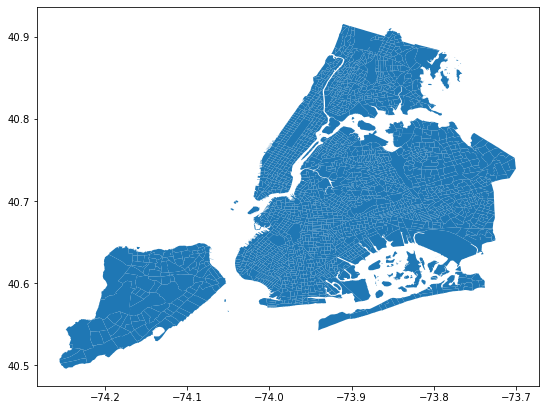

In [99]:
nyc = gpd.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))
nyc.plot(figsize=(9, 9));

### Task 1a: Create a contiguity matrix using the queen criterion.

<div class="alert alert-block alert-info">
<b>Note:</b> PySal will warn us that using contigency for weights results in 7 disconnected components and 3 islands. This is not a problem for our task, but if the data were used in a real analysis, we might want to consider using a different method for creating spatial weights!

You might also get warning about islands and disconnected components later in the analysis. These should not pose a problem, but think about how you could solve this?
</div>

In [100]:
w_queen = weights.Queen.from_dataframe(nyc)

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 3 islands with ids: 0, 626, 2165.
  warnings.warn(message)


### Task 1b: Central Park Neighbours 
* Let's focus on Central Park. Find the corresponding census tract in our nyc dataset. [This map](https://hub.arcgis.com/datasets/DCP::nyc-census-tracts-for-2010-us-census?geometry=-76.267%2C40.341%2C-71.688%2C41.069) can help.
* How many neighbours does Central Park have?
* Make a plot of Central Park and the surrounding area (zoomed in), highlighting all neighbours of Central Park - creating a similar plot as in the lecture (cf. *"Queen neighbors of 708518"*)

In [105]:
cp_ct = 1014300


142

num neighbors 30


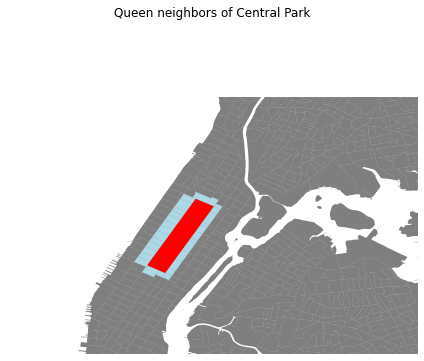

In [106]:
# nyc = nyc.set_index('cartodb_id')
cp_ct = 1014300
cp_id = nyc.loc[nyc.boroct2010 == cp_ct].index[0]
print('num neighbors', w_queen.cardinalities[cp_id])

f, ax = plt.subplots(1, figsize=(6, 6))
nyc.plot(ax=ax, facecolor='k', linewidth=1, alpha=0.5)

focus = nyc.loc[nyc.boroct2010 == cp_ct, ['geometry']]
focus.plot(facecolor='red', alpha=1, linewidth=1, ax=ax)
neis = nyc.loc[list(w_queen[cp_id].keys()), :]
neis.plot(ax=ax, facecolor='lightblue', linewidth=0.5)
f.suptitle("Queen neighbors of Central Park")
ax.set_xlim(-74.05, -73.85)
ax.set_ylim(40.725, 40.85)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Task 1c: Block weights by borough
* Using the 5 boroughs of NYC, create a block spatial weights matrix where every tract is connected to other tracts in the same borough.

In [107]:
w_block = weights.block_weights(nyc.borocode)

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


### Task 1d: Mean number of neighbours for contiguity and block matrices
* Compare the number of neighbours for the contiguity matrix and the block spatial weights matrix. 
* Which criterion gives you which number of neighbours - and why the big difference?*

In [108]:
print('block', w_block.mean_neighbors)
print('queen', w_queen.mean_neighbors)

block 568.7183748845798
queen 6.186518928901201


## Task 2: Distance Weights & Japanese cities

In this task, you will be generating spatial weights matrices based on **distance**. We will use a [dataset](http://www.oecd.org/cfe/regionaldevelopment/functional-urban-areas.htm) of Japanese urban areas provided by [OECD](http://www.oecd.org). Let's get it ready for you to work on it directly.

The data are available over the web on the following address and we can read straight into a GeoDataFrame:

In [109]:
jp = gpd.read_file("data/Japan.shp")

If this does not work, you can find the data in the data folder ('Japan.shp').

In [110]:
# inspect the data set
jp.head()

,fuacode_si,fuaname,fuaname_en,class_code,iso3,name,geometry
0,JPN19,Kagoshima,Kagoshima,3.0,JPN,Japan,"MULTIPOLYGON Z (((130.67888 31.62931 0.00000, ..."
1,JPN20,Himeji,Himeji,3.0,JPN,Japan,"MULTIPOLYGON Z (((134.51537 34.65958 0.00000, ..."
2,JPN50,Hitachi,Hitachi,3.0,JPN,Japan,"POLYGON Z ((140.58715 36.94447 0.00000, 140.61..."
3,JPN08,Hiroshima,Hiroshima,3.0,JPN,Japan,"MULTIPOLYGON Z (((132.29648 34.19932 0.00000, ..."
4,JPN03,Toyota,Toyota,4.0,JPN,Japan,"MULTIPOLYGON Z (((137.04096 34.73242 0.00000, ..."


If we make a quick plot, we can see these are polygons covering the part of the Japanese geography that is considered urban:

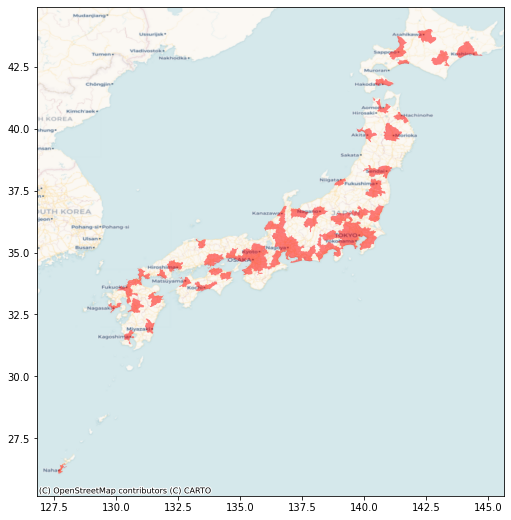

In [111]:
ax = jp.plot(color="red", alpha=0.5, figsize=(9, 9))
cx.add_basemap(ax, crs=jp.crs, source=cx.providers.CartoDB.Voyager)

For this example, we need two transformations: 
- lon/lat coordinates to a geographical projection
- polygons to points. 

To calculate distances effectively, we need to ensure the coordinates of our geographic data are expressed in metres (or a similar measurement unit). The original dataset is expressed in lon/lat degrees:

In [112]:
jp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can use the Japan Plane Rectangular CS XVII system ([`EPSG:2459`](http://epsg.io/2459)), which is expressed in metres:

In [113]:
jp = jp.to_crs(epsg=2459)

So the resulting table is in metres:

In [114]:
jp.crs

<Derived Projected CRS: EPSG:2459>
Name: JGD2000 / Japan Plane Rectangular CS XVII
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Japan - onshore Okinawa-ken east of 130°E.
- bounds: (131.12, 24.4, 131.38, 26.01)
Coordinate Operation:
- name: Japan Plane Rectangular CS zone XVII
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Distances are easier to calculate between points than between polygons. Hence, we will **convert the urban areas into their centroids**:

In [115]:
jp_c = jp.copy()
jp_c.geometry = jp.geometry.centroid

In [116]:
jp_c.head()

,fuacode_si,fuaname,fuaname_en,class_code,iso3,name,geometry
0,JPN19,Kagoshima,Kagoshima,3.0,JPN,Japan,POINT (-46856.955 623832.951)
1,JPN20,Himeji,Himeji,3.0,JPN,Japan,POINT (333569.177 997075.925)
2,JPN50,Hitachi,Hitachi,3.0,JPN,Japan,POINT (858065.798 1229877.615)
3,JPN08,Hiroshima,Hiroshima,3.0,JPN,Japan,POINT (123222.438 939303.154)
4,JPN03,Toyota,Toyota,4.0,JPN,Japan,POINT (537285.936 1047382.748)


So the result is a seet of points expressed in metres:

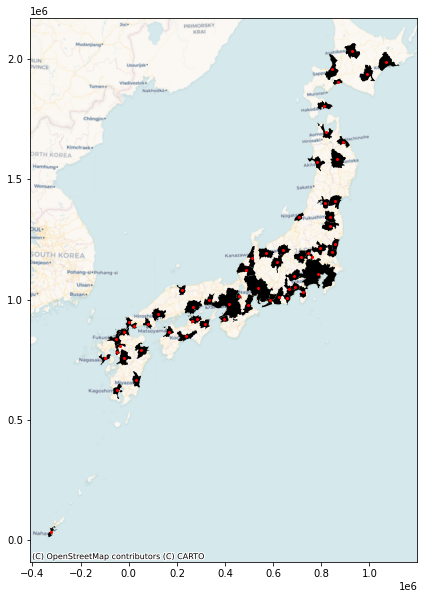

In [117]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
jp.plot(ax = ax, color ="black")
jp_c.plot(ax = ax, markersize = 4, color = "red")
cx.add_basemap(ax, crs=jp.crs, source=cx.providers.CartoDB.Voyager)
plt.show()

### Task 2a
* Create two spatial weights matrices based on **distance**: one with the five nearest neighbours; one with a 100km distance band. 
* Remember to consider the correct distance unit in the dataset!
* Compare the mean number of neighbours for both spatial weight matrices. 
* **What are the main differences you can spot? In which cases do you think one criterion would be preferable over the other?**

In [118]:
w_knn = weights.KNN.from_dataframe(jp_c, k=5)
w_dist = weights.DistanceBand.from_dataframe(jp_c, 100000)
print(f'mean\nknn: {w_knn.mean_neighbors}\ndist: {w_dist.mean_neighbors}')

mean
knn: 5.0
dist: 3.4098360655737703


/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 4 islands with ids: 14, 17, 30, 54.
  warnings.warn(message)


### Task 2b: Tokyo Plotting Challenge (optional)

Focus on Tokyo and the 100km spatial weights matrix generated above. Make a plot where you visualize Tokyo, the 100km distance band, and highlight all neighbouring cities that lie within the distance band.

An optional recipe to follow:

0. Find Tokyo in our jp dataset
1. Generate a [buffer](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) of 100km around the Tokyo centroid.
2. Start the plot with the Tokyo urban area polygon (from `jp_cities`)
3. Plots its neighbours (within the buffer)
4. Plot the neighbours' centroids (points)
5. Plot the buffer on top
6. Add a basemap

Your figure should look similar to:

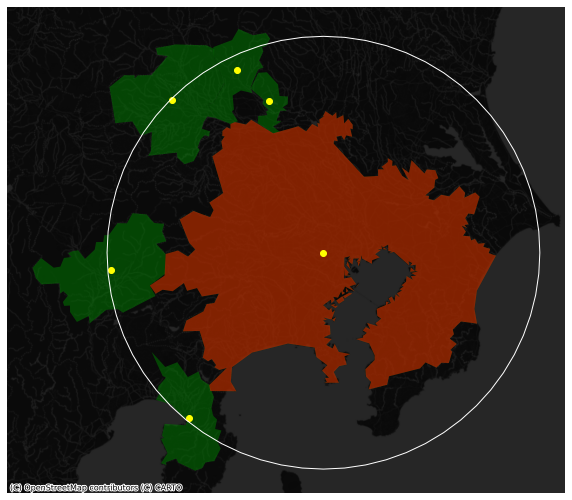

In [163]:
f, ax = plt.subplots(figsize=(10,10))

tokyo = jp.fuaname == 'Tokyo'
tokyo_buffer = jp_c[tokyo].buffer(100000) 
zone = tokyo_buffer.iloc[0]

mask = jp_c.within(zone)
jp[mask].plot(ax=ax, facecolor='green', edgecolor='none', alpha=.5)
jp[tokyo].plot(ax=ax, facecolor='red', edgecolor='none', alpha=.5)
jp_c[mask].plot(ax=ax, color='yellow')
tokyo_buffer.plot(ax=ax, facecolor='none', edgecolor='white')
cx.add_basemap(ax, crs=jp.crs, source=cx.providers.CartoDB.DarkMatterNoLabels)

ax.set_axis_off()